# SELICRD Model

S - susceptable, E - exposed, L - latent, I - infected, C - critical, R - recovered, D - dead

Following:
https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

![title](model.jpg)

In [1]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
import re
base_dir = 'Data'

First, we define the system of differential equations modelling the flow between compartments

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \beta  S \dfrac{I + L}{N}\\
\dfrac{\delta E}{\delta t} &= \beta  S \dfrac{I + L}{N} - \delta  E\\
\dfrac{\delta L}{\delta t} &= \delta  E - \epsilon  p_{L\rightarrow R}  L - \theta  (1 - p_{L\rightarrow R})  L\\
\dfrac{\delta I}{\delta t} &= \theta  (1 - p_{L\rightarrow R})  L - \gamma  (1 - p_{I\rightarrow C})  I  -\lambda  p_{I\rightarrow C}  I\\
\dfrac{\delta C}{\delta t} &= \lambda p_{I\rightarrow C}  I - \tau  \cdot (1 - p_{C\rightarrow D})  \cdot min(beds(t), C) - 
\rho  \cdot p_{C\rightarrow D}  \cdot \min(beds(t), C) - \max(0, C - beds(t))\\
\dfrac{\delta R}{\delta t} &= \gamma  (1 - p_{I\rightarrow R})  I + \tau  (1 - p_{C\rightarrow D})  \cdot \min(beds(t), C) + \epsilon  p_{L\rightarrow R}  L\\
\dfrac{\delta D}{\delta t} &= \rho  \cdot p_{C\rightarrow D}  \cdot min(beds(t), C) + max(0, C-beds(t))
\end{align*}$$

In [3]:
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    dSdt = -beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

We can model the declining R0 as a logistical interpolation as "Stay at Home" orders are released and followed. 

In [4]:
# def logistic_R_0(t, R_0_start, k, x0, R_0_end):
#     if -k*(-t+x0) >= 500: return R_0_end
#     return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
def R0_t(t, b, r_s):
    return (2 / np.pi) * np.arctan(-(t - b) / 10 * r_s) + 1.0

We can find the numerical solution to the ODEs 

In [5]:
# def Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#     # infection rate comes from current R0
#     def beta(t):
#         return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
#     # model bed usage in the poplation
#     def beds(t):
#         beds_0 = beds_per_10k / 10_000 * N
#         return beds_0 + s*beds_0*t  # 0.003
#     # run model
#     N = sum(agegroups)
#     y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
#     t = np.linspace(0, days, days)
#     ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
#     S, E, L, I, C, R, D = ret.T
#     R_0_over_time = [beta(i)/gamma for i in range(len(t))]
#     return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D
def Model(days, agegroups, beds_per_100k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
    def beta(t):
        return alpha*R0_t(t, b, r_s)
    N = sum(agegroups)
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, Beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/alpha for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, Beds, p_I_to_C, p_C_to_D

In [6]:
def plotter(t, S, E, L, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None: 
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax.title.set_text('SELICRD Model')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

Next, define the hyper-parameter rates of the model

In [7]:
gamma = 1.0 / 17.5 # 9 days from infection to recovery
delta = 1.0 / 2.5  # incubation period of four days
epsilon = 1.0 / 14.0 # two weeks for latent person to recover
theta = 1.0 /2.0 # three days for latent to show symptoms
lamda = 1.0 / 11.0 # five days for infected to be critical
tau = 1.0 / 11.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death

## Parameter Fitting

In [8]:
# params_init_min_max = {"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), "p_L_to_R": (0.6, 0.0, 0.8),
#                        "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
#                        "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

params_init_min_max = {#"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), 
                       "p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (0.3, 0.1, 5.7), 
                       "b": (20, 0, 40), "r_s": (1, 0.1, 60),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}


In [19]:
worldData = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", header = 0)
worldData.rename(columns={"countriesAndTerritories" : "country"}, inplace=True)
worldData["country"].replace({"United_States_of_America": "US"}, inplace=True)
worldData

,dateRep,day,month,year,cases,deaths,country,geoId,countryterritoryCode,popData2018,continentExp
0,07/06/2020,7,6,2020,582,18,Afghanistan,AF,AFG,37172386.0,Asia
1,06/06/2020,6,6,2020,915,9,Afghanistan,AF,AFG,37172386.0,Asia
2,05/06/2020,5,6,2020,787,6,Afghanistan,AF,AFG,37172386.0,Asia
3,04/06/2020,4,6,2020,758,24,Afghanistan,AF,AFG,37172386.0,Asia
4,03/06/2020,3,6,2020,759,5,Afghanistan,AF,AFG,37172386.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...
21960,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
21961,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
21962,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
21963,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


In [20]:
set(worldData["country"])

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua_and_Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire, Saint Eustatius and Saba',
 'Bosnia_and_Herzegovina',
 'Botswana',
 'Brazil',
 'British_Virgin_Islands',
 'Brunei_Darussalam',
 'Bulgaria',
 'Burkina_Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape_Verde',
 'Cases_on_an_international_conveyance_Japan',
 'Cayman_Islands',
 'Central_African_Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa_Rica',
 'Cote_dIvoire',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'Democratic_Republic_of_the_Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican_Republic',
 'Ecuador',
 'Egypt',
 'El_Salvador',
 'Equatorial_Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fa

In [42]:
country = "China"
countryData = worldData[worldData.country == country][::-1].reset_index(drop=True)
countryData

,dateRep,day,month,year,cases,deaths,country,geoId,countryterritoryCode,popData2018,continentExp
0,31/12/2019,31,12,2019,27,0,China,CN,CHN,1.392730e+09,Asia
1,01/01/2020,1,1,2020,0,0,China,CN,CHN,1.392730e+09,Asia
2,02/01/2020,2,1,2020,0,0,China,CN,CHN,1.392730e+09,Asia
3,03/01/2020,3,1,2020,17,0,China,CN,CHN,1.392730e+09,Asia
4,04/01/2020,4,1,2020,0,0,China,CN,CHN,1.392730e+09,Asia
...,...,...,...,...,...,...,...,...,...,...,...
155,03/06/2020,3,6,2020,5,0,China,CN,CHN,1.392730e+09,Asia
156,04/06/2020,4,6,2020,1,0,China,CN,CHN,1.392730e+09,Asia
157,05/06/2020,5,6,2020,11,0,China,CN,CHN,1.392730e+09,Asia
158,06/06/2020,6,6,2020,6,0,China,CN,CHN,1.392730e+09,Asia


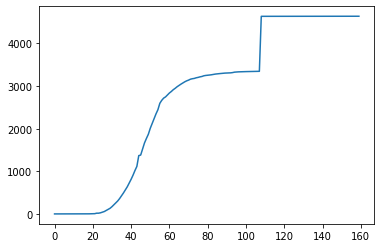

In [43]:

plt.plot(np.cumsum(countryData["deaths"]))

In [45]:
countryData["deaths"][100:120]

100       2
101       1
102       3
103       0
104       2
105       0
106       1
107       0
108    1290
109       0
110       0
111       0
112       0
113       0
114       0
115       0
116       0
117       0
118       1
119       0
Name: deaths, dtype: int64

In [47]:
countryData["dateRep"][108]

'17/04/2020'

In [23]:
def run_and_plot(country, outbreak_shift):
    #deaths
    if country == 'China': 
        countryData = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
        # rename the column header so that it is same as other data
        countryData.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
#     else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    else:
        worldData = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", header = 0)
        worldData.rename(columns={"countriesAndTerritories" : "country"}, inplace=True)
        worldData.rename(columns={"dateRep" : "date"}, inplace=True)
        worldData["country"].replace({"United_States_of_America": "US"}, inplace=True)
        worldData["country"].replace({"United_Kingdom": "UK"}, inplace=True)
        
        countryData = worldData[worldData.country == country][::-1].reset_index(drop=True)
        
        # Handling anormally: make sure no negative number of deaths
        # in Spain data, row index 146 has -1918 number of deaths which doesn't make sense
        # make negative number of deaths to be zero
        countryData.loc[countryData["deaths"] < 0] = 0

        # create cumulative columns
        countryData["cases_ttl"] = np.cumsum(countryData["cases"])
        countryData["deaths_ttl"] = np.cumsum(countryData["deaths"])
    
    # find the case when equal or more than 100 infection cases detected
    countryData = countryData.loc[countryData["cases_ttl"].values>=100]
    deathData = countryData["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(deathData)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), deathData))
    else: y_data = deathData[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    # fit model to deaths
#     def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#         ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
#         return ret[7][x]
    def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
        ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
        return ret[7][x]
    mod = lmfit.Model(fitter)
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    params = mod.make_params()
    fit_method = "leastsq"
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    print(result.best_values)
    print(np.mean(result.residual **2))
    
    # forward predict
    dates = countryData["date"].values
    first_date = dates[0]
    full_days = len(y_data) + 30
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    predict_range = full_days - len(y_data)
    forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
    death_projection = forecast[7]
    
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label="Data")
    ax.plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
    ax.plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")
    label_idx = np.arange(0, len(x_ticks), 15)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(death_projection))
    label_location = location[label_idx]; ax.set_xticks(label_location)
    ax.set_xticklabels(labels, rotation=45); ax.set_ylabel("Deaths")
    ax.set_title(country) ;ax.legend() ;fig.autofmt_xdate(); plt.show()

#     # plot 
#     full_days = 500 ## let's predict full 200 days
#     x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
#     print("Prediction for " + country)
#     plotter(*Model(full_days, agegroups, beds_per_10k, **result.best_values), x_ticks=x_ticks);

## United States

{'alpha': 1.352824155062176, 'b': 18.302665496291652, 'r_s': 10.624078744873028, 'p_L_to_R': 6.318586456512514e-07, 'p_I_to_C': 0.006891347268045967, 'p_C_to_D': 0.7999788562145761, 's': 0.003}
687044.958246151


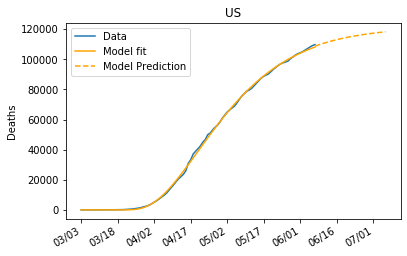

In [13]:
run_and_plot("US", 0)

## China

{'alpha': 3.873377748832393, 'b': 6.46293158557053, 'r_s': 59.99850797449941, 'p_L_to_R': 4.280046212626597e-10, 'p_I_to_C': 0.09999980794408928, 'p_C_to_D': 0.7999999995552995, 's': 0.003}
200143.0341891682


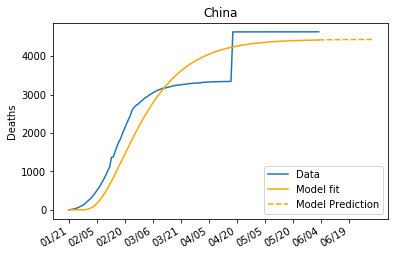

In [14]:
run_and_plot("China", 0)

## Brazil

{'alpha': 5.699998186869982, 'b': 3.0864014956482677, 'r_s': 9.52732358698104, 'p_L_to_R': 4.746959697405186e-15, 'p_I_to_C': 0.09999978508856917, 'p_C_to_D': 0.799999134496555, 's': 0.003}
108485.37426071987


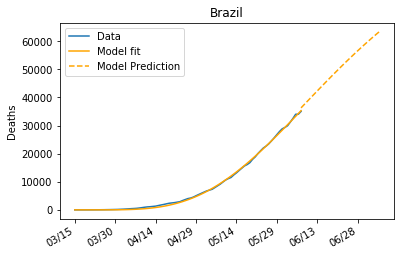

In [15]:
run_and_plot("Brazil", 0)

## India

{'alpha': 5.697858073549582, 'b': 2.4740174443766825, 'r_s': 10.214179853443527, 'p_L_to_R': 8.0624415668562235e-28, 'p_I_to_C': 0.08573251552849095, 'p_C_to_D': 0.7999999999594393, 's': 0.003}
17813.497310856314


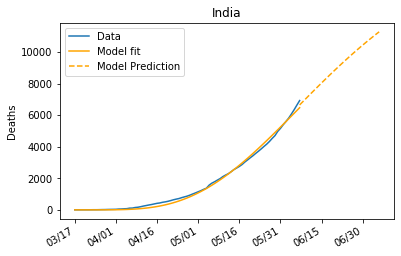

In [17]:
run_and_plot("India", 0)

## Germany

{'alpha': 0.7529380940011403, 'b': 21.00301887276589, 'r_s': 57.48467707166345, 'p_L_to_R': 0.7999999999954904, 'p_I_to_C': 0.09999971936034822, 'p_C_to_D': 0.7999995197731405, 's': 0.003}
3846.4107741472226


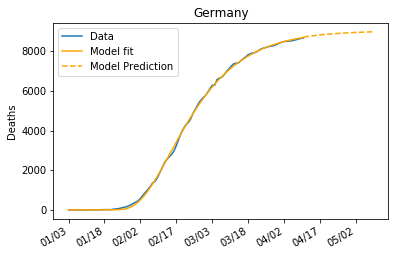

In [18]:
run_and_plot("Germany", 0)

## Italy

{'alpha': 3.3766255312189037, 'b': 10.167206097722254, 'r_s': 41.00696847682794, 'p_L_to_R': 0.1394131618921413, 'p_I_to_C': 0.006723832575874285, 'p_C_to_D': 0.7999999999999999, 's': 0.0033757514270682594}
23750.255939519324


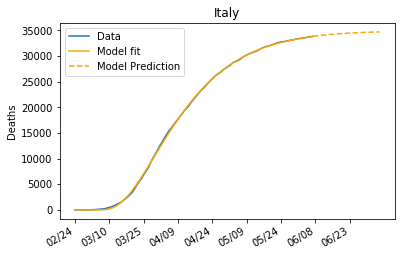

In [19]:
run_and_plot("Italy", 0)

## Spain

{'alpha': 2.2019769121184343, 'b': 10.949847147434209, 'r_s': 59.999999869339284, 'p_L_to_R': 3.433526648925856e-12, 'p_I_to_C': 0.09999999999940191, 'p_C_to_D': 0.799999990482938, 's': 0.003993327142925598}
459171.1461336772


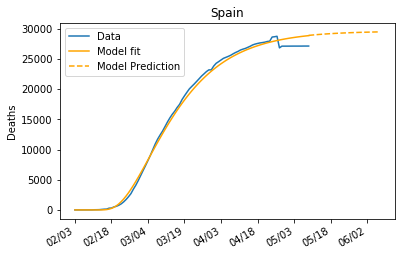

In [20]:
run_and_plot("Spain", 0)

## United Kingdom

{'alpha': 1.8750921333354391, 'b': 14.520999186388833, 'r_s': 23.242257279515908, 'p_L_to_R': 2.8883571738958014e-05, 'p_I_to_C': 0.006552566207861973, 'p_C_to_D': 0.7999975528079376, 's': 0.0043026463029680224}
75454.74976714485


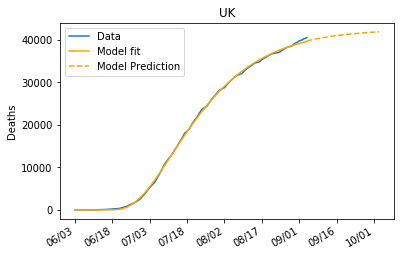

In [21]:
run_and_plot("UK", 0)

## France

{'alpha': 0.9126561060624657, 'b': 19.096276432676497, 'r_s': 59.9975869258054, 'p_L_to_R': 0.0008153425709305132, 'p_I_to_C': 0.0999999227901387, 'p_C_to_D': 0.7999999999226021, 's': 0.003}
240859.07272987426


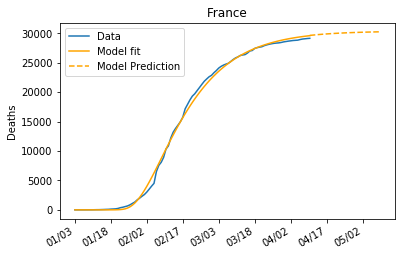

In [22]:
run_and_plot("France", 0)

## Canada

{'alpha': 1.4883777263992604, 'b': 11.746613818021041, 'r_s': 8.2300063610632, 'p_L_to_R': 0.7999999871027271, 'p_I_to_C': 0.0999999998100658, 'p_C_to_D': 0.7999999839373126, 's': 0.003}
3169.4681226214757


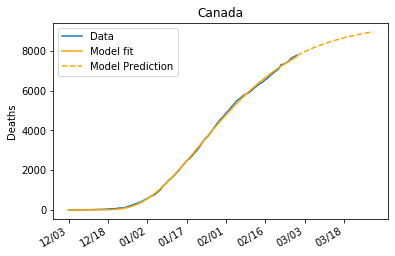

In [24]:
run_and_plot("Canada", 0)

## Netherlands

{'alpha': 2.3096448633225117, 'b': 9.508573358346844, 'r_s': 59.99999704978826, 'p_L_to_R': 0.48386912823885214, 'p_I_to_C': 0.09999999997473813, 'p_C_to_D': 0.7999999995899112, 's': 0.003}
1919.8764686938628


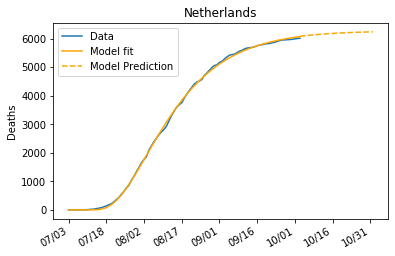

In [25]:
run_and_plot("Netherlands", 0)

## Use Johns Hopkins Global Data 

* Note:


On May 25, Spain announced yet another way of collecting data, by counting a death based on when it happened, instead of when authorities were notified about it.

As a result, the country’s death toll saw a 2,000 drop, and authorities have said that they would update the numbers weekly, warning that more changes might come, while still reporting daily numbers.

* Source : https://www.nytimes.com/interactive/2020/world/europe/spain-coronavirus-cases.html


In [26]:
def run_and_predict(country, outbreak_shift):

    # Use Johns Hopkins github data
    confirmed_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    recoveries_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

    confirmed_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

    confirmed_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
    deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
    recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    
    confirmed_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
    deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
    recoveries_df.rename(columns={"Korea, South" : "South Korea"}, inplace=True)
    
    
    # cols = confirmed_df.keys() gives
    # 'Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20' ... etc
    cols = confirmed_df.keys()

    confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
    deaths = deaths_df.loc[:, cols[4]:cols[-1]]
    recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

    dates = confirmed.keys()

    countryConfirmed = [] 
    countryDeaths = []
    countryRecovery = []

    for i in dates:
        # case studies 
        countryConfirmed.append(confirmed_df[confirmed_df['country']== country ][i].sum())

        countryDeaths.append(deaths_df[deaths_df['country']==country][i].sum())

        countryRecovery.append(recoveries_df[recoveries_df['country']==country][i].sum())

    countryConfirmed = np.array(countryConfirmed)
    countryDeaths = np.array(countryDeaths)
    countryRecovery = np.array(countryRecovery)


    # find the case when equal or more than 100 infection cases detected
    idx = np.where(countryConfirmed>=100)
    deathData = countryDeaths[idx]

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(deathData)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), deathData))
    else: y_data = deathData[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    # fit model to deaths
#     def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#         ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
#         return ret[7][x]
    def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
        ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
        return ret[7][x]
    mod = lmfit.Model(fitter)
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    params = mod.make_params()
    fit_method = "leastsq"
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
#     print(result.best_values)
    print(np.mean(result.residual **2))
    
    # forward predict
#     dates = countryData["date"].values

    first_date = dates[idx][0]
    full_days = len(y_data) + 60
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    predict_range = full_days - len(y_data)
    forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
    death_projection = forecast[7]
      
    return x_data, y_data, death_projection, predict_range, x_ticks, result.best_values, result

265484.8751280653
231610.19495986405
91099.94282536417
9742.60434941256
6360.97669359335
24133.9593931828
505094.2611002262
51989.47168977372
205171.15364259554
2773.418840427029
1878.2795163564765
77.23109254590513


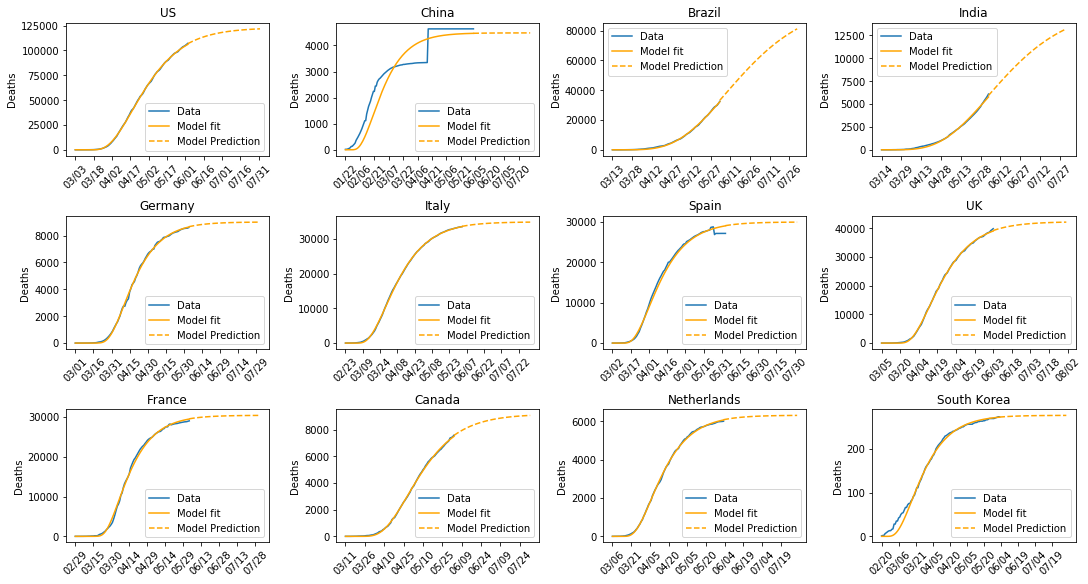

In [27]:
countries = ["US", "China", "Brazil", "India", "Germany", "Italy", "Spain", "UK", "France", "Canada", "Netherlands", "South Korea"]

params_init_min_max = {"p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (0.3, 0.1, 5.7), 
                       "b": (20, 0, 40), "r_s": (1, 0.1, 60),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

fig, axs = plt.subplots(3,4, figsize=(15, 8), constrained_layout=True)
axs = axs.ravel()

country_param_dict = {}
country_death_prediction = {}
country_models = {}
country_dates = {}

for i,country in enumerate(countries):
    x_data, y_data, death_projection, predict_range, x_ticks, best_param, country_model  = run_and_predict(country, 0)
    
    country_param_dict[country] = best_param
    country_death_prediction[country] = (x_data, death_projection)
    country_models[country] = country_model
    country_dates[country] = x_ticks
    
    axs[i].plot(x_data, y_data, label="Data")
    axs[i].plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
    axs[i].plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")
    
    label_idx = np.arange(0, len(x_ticks), 15)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(death_projection))
    label_location = location[label_idx]; axs[i].set_xticks(label_location)
    axs[i].set_xticklabels(labels, rotation=45); axs[i].set_ylabel("Deaths")
    axs[i].set_title(country) ;axs[i].legend() ; #fig.autofmt_xdate(); 

plt.show()

In [28]:
country_death_prediction

{'US': (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
         85, 86, 87, 88, 89, 90, 91, 92]),
  array([0.00000000e+00, 5.87570019e-07, 8.98066319e-06, 4.87135518e-05,
         1.84661349e-04, 6.01471830e-04, 1.83106301e-03, 5.40751424e-03,
         1.57469086e-02, 4.55218932e-02, 1.30939179e-01, 3.74787064e-01,
         1.06596578e+00, 3.00199901e+00, 8.29692956e+00, 2.19380620e+01,
         5.30814296e+01, 1.14405280e+02, 2.20318432e+02, 3.85323131e+02,
         6.22878501e+02, 9.44720572e+02, 1.36052145e+03, 1.87777941e+03,
         2.50185742e+03, 3.23611141e+03, 4.08206885e+03, 5.03963100e+03,
         6.10728204e+03, 7.28229440e+03, 8.56092387e+03

In [29]:

# countries = ["US", "China", "Brazil", "India", "Germany", "Italy", "Spain", "UK", "France", "Canada", "Netherlands", "South Korea"]
country_dates["China"]



DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02'],
              dtype='datetime64[ns]', length=194, freq='D')

In [30]:
country = "China"
len(country_dates[country])

194

In [31]:
import copy

country_interval = {}

for i,country in enumerate(countries):
    
    # get country-specific fitted params
    country_param = country_param_dict[country]

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    full_days = len(country_dates[country])
    
    forecast = Model(full_days, agegroups, beds_per_10k, **country_param)
#     plt.plot(forecast[7], label="projection")

    upper_param = copy.deepcopy(country_param)
    upper_param["p_C_to_D"] = upper_param["p_C_to_D"] + 0.1
    upper_forecast = Model(full_days, agegroups, beds_per_10k, **upper_param) #7th element is predictions
#     plt.plot(upper_forecast[7], label="upper")

    lower_param = copy.deepcopy(country_param)
    lower_param["p_C_to_D"] = lower_param["p_C_to_D"] - 0.1
    lower_forecast = Model(full_days, agegroups, beds_per_10k, **lower_param) #7th element is predictions
#     plt.plot(lower_forecast[7], label="lower")
#     plt.legend()
#     plt.show()

    #Avg deviation of pred upper/lower ranges from pred deaths
    print("\n***********"+ country + "***********")
    print("+",np.mean(upper_forecast[7] - forecast[7]))
    print("-",np.mean(forecast[7] - lower_forecast[7]))
    print("**************************")

    d = {"dates" : country_dates[country], 
         "prediction" :forecast[7],
         "+" :upper_forecast[7] - forecast[7], 
         "-" :lower_forecast[7] - forecast[7]}

    interval_df = pd.DataFrame(data=d)
    country_interval[country] = copy.deepcopy(interval_df)
    
    country_interval[country].to_csv(country+"projection")
    #df.to_csv('file_name.csv')
    


***********US***********
+ 6380.330853747576
- 6832.34686573504
**************************

***********China***********
+ 301.28429596937883
- 323.4159049890914
**************************

***********Brazil***********
+ 2685.321898481964
- 2863.5136189095897
**************************

***********India***********
+ 461.21735669494996
- 492.0426294687342
**************************

***********Germany***********
+ 520.6643812433766
- 557.9130796911929
**************************

***********Italy***********
+ 2104.0878121399064
- 2255.685354739498
**************************

***********Spain***********
+ 1866.2586577693476
- 2000.54179355579
**************************

***********UK***********
+ 2387.304705550825
- 2557.421373283333
**************************

***********France***********
+ 1821.0625615562242
- 1951.8018576578354
**************************

***********Canada***********
+ 458.3415616341462
- 490.5133855077723
**************************

***********Netherlands***********
+

In [32]:
country_interval["US"]

,dates,prediction,+,-
0,2020-03-03,0.000000e+00,0.000000e+00,0.000000e+00
1,2020-03-04,5.875700e-07,7.295441e-08,-7.308993e-08
2,2020-03-05,8.980663e-06,1.106332e-06,-1.110316e-06
3,2020-03-06,4.871355e-05,5.961211e-06,-5.991445e-06
4,2020-03-07,1.846613e-04,2.248381e-05,-2.262278e-05
...,...,...,...,...
148,2020-07-29,1.215708e+05,1.032017e+04,-1.111793e+04
149,2020-07-30,1.216323e+05,1.032402e+04,-1.112227e+04
150,2020-07-31,1.216910e+05,1.032769e+04,-1.112640e+04
151,2020-08-01,1.217471e+05,1.033118e+04,-1.113035e+04


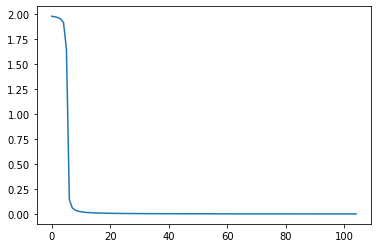

In [33]:
country = "South Korea"
# Use Johns Hopkins github data
confirmed_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_df.rename(columns={"Country/Region" : "country"}, inplace=True)
deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

confirmed_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

confirmed_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
recoveries_df.rename(columns={"Korea, South" : "South Korea"}, inplace=True)


# cols = confirmed_df.keys() gives
# 'Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20' ... etc
cols = confirmed_df.keys()

confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()

countryConfirmed = [] 
countryDeaths = []
countryRecovery = []

for i in dates:
    # case studies 
    countryConfirmed.append(confirmed_df[confirmed_df['country']== country ][i].sum())

    countryDeaths.append(deaths_df[deaths_df['country']==country][i].sum())

    countryRecovery.append(recoveries_df[recoveries_df['country']==country][i].sum())

countryConfirmed = np.array(countryConfirmed)
countryDeaths = np.array(countryDeaths)
countryRecovery = np.array(countryRecovery)


# find the case when equal or more than 100 infection cases detected
idx = np.where(countryConfirmed>=100)
deathData = countryDeaths[idx]

days = len(deathData)
t = np.linspace(0, days-1, days)

b = 5.276639391784356
r_s = 59.99999980327082

r0 = R0_t(t, b, r_s)

plt.plot(t, r0)

# def R0_t(t, b, r_s):
#     return (2 / np.pi) * np.arctan(-(t - b) / 10 * r_s) + 1.0


# Validation

In [ ]:
from sklearn.model_selection import train_test_split

def Validate(country):
    outbreak_shift = 0
    
    if country == 'China': 
        deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
        # rename the column header so that it is same as other data
        deaths.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
    else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    
    deaths = deaths[deaths.country == country]

    # find the case when equal or more than 100 infection cases detected
    deaths = deaths.loc[deaths["cases_ttl"].values>=100]
    data = deaths["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else: y_data = data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array


    # This represents test size to be the last 30%, 20% and 10% of data
    test_sizes = [0.3, 0.2, 0.1, 0.05] 

    param_vec = []
    test_errors = []
    train_errors = []

    print("Country:", country)
    for test_size in test_sizes:
        print("Test set proportion:", test_size)
        X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle = False) # make sure shuffle is False

        def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
                ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
                return ret[7][x]
        mod = lmfit.Model(fitter)
        for kwarg, (init, mini, maxi) in params_init_min_max.items():
            mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
        params = mod.make_params()
        fit_method = "leastsq"
        result = mod.fit(Y_train, params, method="least_squares", x=X_train)

        ## store parameter values
        param_vec.append(result.best_values)

        # forward predict
        full_days = len(x_data)
        forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
        death_projection = forecast[7]

        #L2 norm error
        #train_error = np.linalg.norm(Y_train - death_projection[:len(Y_train)], 2) ## divide by number of train set
        #test_error = np.linalg.norm(Y_test - death_projection[-len(Y_test):], 2) ## divide by number of test set

        #Mean-Absolute-Prediction-Error (MAPE)
        #train_error = np.mean(np.absolute((Y_train - death_projection[:len(Y_train)])/death_projection[:len(Y_train)]))
        test_error = np.mean(np.absolute((Y_test - death_projection[-len(Y_test):])/death_projection[-len(Y_test):]))
        
        #print("Train Error: {0}".format( train_error ))
        print("Test Error: {0}".format( test_error ))

        #train_errors.append(train_error)
        test_errors.append(test_error)

    best_case = np.argmin(test_errors)
    best_parameters = param_vec[best_case]

    print("Best Validation case is when test size is remaining {0} %".format(test_sizes[best_case]*100))
    
    plt.figure()
    plt.plot((1-np.array(test_sizes)) * 100, test_errors)
    plt.xlabel("Train Set Percentage")
    plt.ylabel(r"$L_2$ Norm Error")
    plt.title("{0} Data Validation".format(country))
    plt.show()
    
    return best_parameters

In [ ]:
best_param_each_country = dict()

best_param_each_country["US"] = Validate("US")

In [ ]:
best_param_each_country["China"]  = Validate("China")

In [ ]:
best_param_each_country["Brazil"]  = Validate("Brazil")

In [ ]:
India_best_param = Validate("India")

In [ ]:
Germany_best_param = Validate("Germany")

In [ ]:
Italy_best_param = Validate("Italy")

In [ ]:
Spain_best_param = Validate("Spain")

In [ ]:
UK_best_param = Validate("UK")

In [ ]:
France_best_param = Validate("France")

In [ ]:
Canada_best_param = Validate("Canada")

In [ ]:
Netherlands_best_param = Validate("Netherlands")

# Predict Severe Cases from Predicted Deaths

In [ ]:
#Need: date | actual deaths | pred deaths | pred deaths low| pred deaths high | actual severe | pred severe | pred severe low | pred severe high

In [34]:
#JHU General deaths data
deaths_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)    
deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)

In [35]:
#Function to get [date | actual deaths | pred deaths | pred deaths low| pred deaths high] for country
#Note: Not all countries have death data (e.g. Canada shows all 0s for reported deaths)
def get_deathsdata(country, actual_deaths = None):
    #Get pred deaths
    country_pred_deaths = copy.deepcopy(country_interval[country])
    country_pred_deaths["deaths_pred_low"] = country_pred_deaths["prediction"] + country_pred_deaths["-"]
    country_pred_deaths["deaths_pred_high"] = country_pred_deaths["prediction"] + country_pred_deaths["+"]
    country_pred_deaths["dates"] = country_pred_deaths["dates"].astype("string")

    country_pred_deaths.rename(columns={"dates" : "date", "prediction" : "deaths_pred"}, inplace=True)
    country_pred_deaths = country_pred_deaths.drop(columns = ["+","-"])

    if (actual_deaths is None):
        #Get actual deaths (JHU data)
        cols = deaths_df.keys()
        deaths = deaths_df.loc[:, cols[4]:cols[-1]]
        dates = deaths.keys()
        countryDeaths = []

        for i in dates:
            countryDeaths.append(deaths_df[(deaths_df["country"]==country) & (pd.isnull(deaths_df["Province/State"]))][i].sum())

        countryDeaths = np.array(countryDeaths)
        country_actual_deaths = {'date' : pd.to_datetime(np.array(dates)).strftime('%Y-%m-%d'), 'deaths_ttl' : np.array(countryDeaths)}
        country_actual_deaths = pd.DataFrame(country_actual_deaths)

    else:
        country_actual_deaths = actual_deaths
        
    #Join the two
    country_deaths = pd.merge(country_pred_deaths, country_actual_deaths,
                              how='left', 
                              left_on=["date"], 
                              right_on = ["date"])
    return(country_deaths)

In [36]:
#Get severe case data separately since it comes from diff sources with diff formatting needs

In [52]:
#Function to make severe case predictions
#Input data in format [date | deaths_ttl | deaths_pred | deaths_pred_low | deaths_pred_high | severe_ttl]
#Returns a pandas df with 
# [dateind | date | deaths_ttl | deaths_pred | deaths_pred_low |deaths_pred_high | severe_ttl | pred_severe | pred_severe_low | pred_severe_high]
def predict_severe(data, c, window_size = 15, lag_days = 3):
    data = data.reset_index(drop=True)
    data["dateind"] = data.index
    
    #Filter for deaths, dropping missing obs
    deaths = data[["dateind", "deaths_pred", "deaths_pred_low", "deaths_pred_high"]].dropna()
    deaths = deaths.reset_index(drop=True)
    
    #Add severe case prediction category (= slope * c)
    deaths["severe_pred"] = np.nan
    deaths["severe_pred_low"] = np.nan
    deaths["severe_pred_high"] = np.nan
        
    #Calculate slopes over a rolling window
    for i in range(window_size, deaths.shape[0]+1):
        X = deaths[i-window_size: i]["dateind"].to_numpy().reshape(-1, 1)
        Y1 = deaths[i-window_size: i]["deaths_pred"].to_numpy().reshape(-1, 1)
        Y2 = deaths[i-window_size: i]["deaths_pred_low"].to_numpy().reshape(-1, 1)
        Y3 = deaths[i-window_size: i]["deaths_pred_high"].to_numpy().reshape(-1, 1)
        
        #Pred
        regressor1 = LinearRegression()  
        regressor1.fit(X, Y1)
        deaths.at[i-lag_days,"severe_pred"] = regressor1.coef_[0] * c
        
        #Pred_low
        regressor2 = LinearRegression()  
        regressor2.fit(X, Y2)
        deaths.at[i-lag_days,"severe_pred_low"] = regressor2.coef_[0] * c
        
        #Pred_high
        regressor3 = LinearRegression()  
        regressor3.fit(X, Y3)
        deaths.at[i-lag_days,"severe_pred_high"] = regressor3.coef_[0] * c

    #Join back onto full data
    data = pd.merge(data, deaths,  
                    how='left')
    
    return(data)

In [91]:
#Function to plot results
def plot_preds(data):
    plt.plot(data["date"], data["deaths_ttl"], label = "True Deaths")
    plt.plot(data["date"], data["severe_ttl"], label = "True Severe")
    
    plt.plot(data["date"], data["deaths_pred"], label = "Pred Deaths", linestyle = "--")
    plt.fill_between(data["date"], data["deaths_pred_low"], data["deaths_pred_high"], color='b', alpha=.1)

    plt.plot(data["date"], data["severe_pred"], label = "Pred Severe", linestyle = "--")
    plt.fill_between(data["date"], data["severe_pred_low"], data["severe_pred_high"], color='r', alpha=.1)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    #plt.xticks(rotation=45)
    
    x_ticks = pd.date_range(start=data['date'].min(), end = data['date'].max(), freq="D")
    label_idx = np.arange(0, len(x_ticks), 10)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(data[["deaths_pred"]]))
    label_location = label_idx
    plt.xticks(ticks = label_location, labels = labels, rotation = 50)
    #plt.xticks(labels, rotation=45);
    
    
    plt.show()

# US

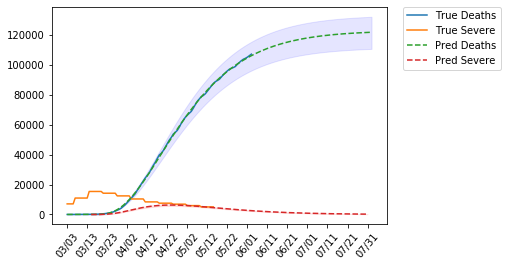

In [92]:
#US
us_deaths = get_deathsdata("US")

us_severe = pd.read_csv("Data/US_ED_CLI_visits_clean.csv", header = 0)
us_severe["CLI_ED_visits"] = us_severe[["CLI_ED_visits"]].replace(',', '', regex=True)
us_severe["CLI_ED_visits"] = pd.to_numeric(us_severe["CLI_ED_visits"])
us_severe = us_severe[["date", "CLI_ED_visits"]]
us_severe.rename(columns={"CLI_ED_visits" : "severe_ttl"}, inplace=True)

us = pd.merge(us_deaths, us_severe,  
              how='left', 
              left_on=["date"], 
              right_on = ["date"])
us["severe_ttl"] = us["severe_ttl"].bfill()/7 #Last observation carried backwards, daily avg

us_preds = predict_severe(us,3)
plot_preds(us_preds)

# Canada

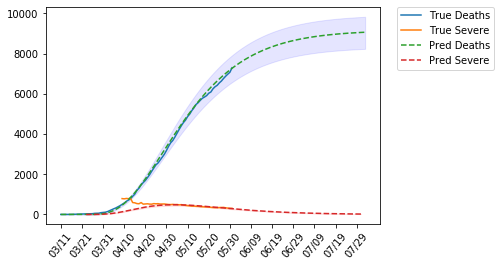

In [93]:
#Canada
canada_deaths = get_deathsdata("Canada")
canada_deaths = canada_deaths.drop(["deaths_ttl"], axis = 1)

canada_severe = pd.read_csv("Data/Canada_severe_case_data.csv", header = 0)
canada_severe = canada_severe[canada_severe["Province"] == "CANADA"][["SummaryDate", "TotalDeaths", "TotalICU"]]
canada_severe = canada_severe.rename(columns = {"SummaryDate":"date", "TotalDeaths":"deaths_ttl", "TotalICU":"severe_ttl"})
canada_severe[["date"]] = canada_severe[["date"]].replace('/', '-', regex=True)
canada_severe[["date"]] = canada_severe[["date"]].replace(' .*', '', regex=True)

canada = pd.merge(canada_deaths, canada_severe,  
              how='left', 
              left_on=["date"], 
              right_on = ["date"])

canada_preds = predict_severe(canada, 3)
plot_preds(canada_preds)

# China

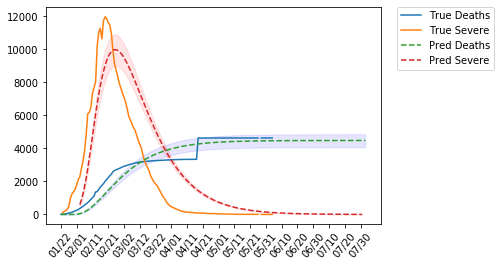

In [94]:
#China
#(Note: Predicting on actual deaths gives better results since slope of pred and actual deaths curves are diff)
china_deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
china_deaths = china_deaths[["date", "deaths_ttl"]]
china_deaths = get_deathsdata("China", china_deaths)

china_severe = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
china_severe = china_severe[["date", "severe_ttl"]]
china = pd.merge(china_deaths, china_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])

china_preds = predict_severe(china, 100)
plot_preds(china_preds)

# South Korea

# France

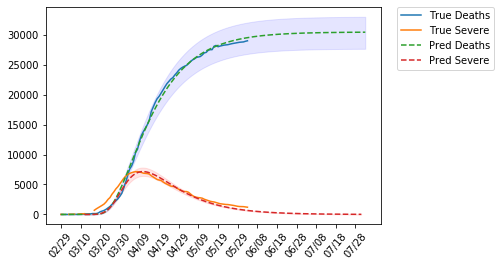

In [95]:
#France
france_deaths = get_deathsdata("France")
france_severe = pd.read_csv("Data/france_cases_deaths_severe_recovered_ministresante.csv", header = 0)
france = pd.merge(france_deaths, france_severe[["date", "severe_ttl"]],  
              how='left', 
              left_on=["date"], 
              right_on = ["date"])

france_preds = predict_severe(france, 9)
plot_preds(france_preds)

# Italy

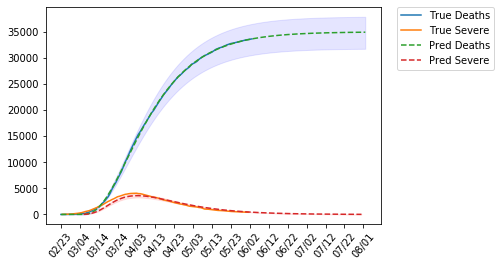

In [96]:
italy_deaths = get_deathsdata("Italy")

italy_severe = pd.read_csv("Data/italy_daily_severe_hosp.csv", header = 0)
italy_severe = italy_severe[["data","terapia_intensiva"]]
italy_severe = italy_severe.rename(columns={"data":"date", "terapia_intensiva":"severe_ttl"})
italy_severe[["date"]] = italy_severe[["date"]].replace('T.*', '', regex=True)

italy = pd.merge(italy_deaths, italy_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])
                 
italy = predict_severe(italy, 5)
plot_preds(italy)

# Spain

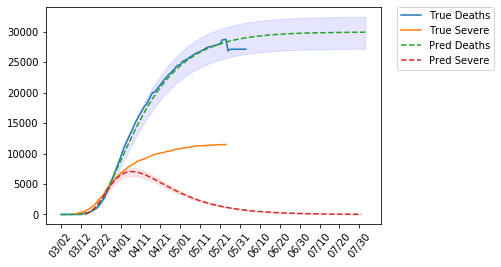

In [97]:
spain_deaths = get_deathsdata("Spain")

spain_severe = pd.read_csv("Data/spain_icu_hospitalization.csv", header = 0)
spain_severe = spain_severe[["fecha","total_hosp"]]
spain_severe = spain_severe.rename(columns={"fecha":"date", "total_hosp":"severe_ttl"})

spain = pd.merge(spain_deaths, spain_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])

spain_preds = predict_severe(spain, 10)
plot_preds(spain_preds)

# Germany

# UK

# Netherlands

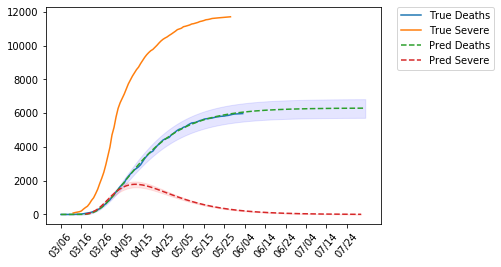

In [98]:
neth_deaths = get_deathsdata("Netherlands")

neth_severe = pd.read_csv("Data/netherlands_hospitalization_statista.csv", header = 0)
neth_severe = neth_severe[["date", "hospitalizations_ttl"]]
neth_severe = neth_severe.rename(columns = {"deaths":"deaths_ttl", "hospitalizations_ttl":"severe_ttl"})

neth = pd.merge(neth_deaths, neth_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])

neth_preds = predict_severe(neth, 12)
plot_preds(neth_preds)

# Brazil

# India